<a href="https://colab.research.google.com/github/HelloIAmOleg/srgan/blob/master/SR_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [38]:
%tensorflow_version 1.x
import tensorflow
tensorflow.__version__

'1.15.2'

000000463647.jpg


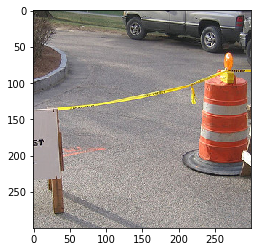

In [0]:
"""import os
import PIL
import tensorflow.keras.preprocessing.image as img
import matplotlib.pyplot as plt
files = os.listdir(path = '/content/gdrive/My Drive/val2017')
print(files[0])
image = img.load_img(path ='/content/gdrive/My Drive/val2017/' + files[0])
image = img.img_to_array(image)
w = image.shape[0]
h = image.shape[1]
image = image[(w-300)//2:(w+300)//2,(h-300)//2:(h+300)//2,:]
plt.imshow(img.array_to_img(image))"""

Images Preparation

In [0]:
import numpy as np
from numpy import array
from PIL import Image
import os
import tensorflow.keras.preprocessing.image as img
import matplotlib.pyplot as plt

def crop(img):
    w = img.shape[0]
    h = img.shape[1]
    img = img[(w-300)//2:(w+300)//2,(h-300)//2:(h+300)//2,:]
    return img

def get_images(directory, num):
    file_list = os.listdir(path = directory)
    file_list = file_list[:num]
    raw_imgs = []
    i = 0
    for f in file_list:
      if (img.img_to_array(img.load_img(path = directory + '/' + f))).shape[0]>300 and (img.img_to_array(img.load_img(path = directory + '/' + f))).shape[1]>300:
       raw_imgs.append(crop(img.img_to_array(img.load_img(path = directory + '/' + f))))
      #  plt.imshow(img.load_img(path = directory + '/' + f))
      #  plt.imshow(img.array_to_img(crop(img.img_to_array(img.load_img(path = directory + '/' + f)))))
       i = i + 1
      if i % 10 == 0:
        print ("%d images uploaded"%i)
    #raw_imgs = [crop(img.img_to_array(img.load_img(path = directory + '/' + f))) for f in file_list]
    imgs = array(raw_imgs)
    print("%d images uploaded in total"%i)
    return imgs

"""# Takes list of images and provides HR images in form of a numpy array
def hr_images(images):
    images_hr = array(images)
    return images_hr"""

# Takes list of images and provides LR images in form of a numpy array
def lr_images(images_real , downscale):   
    images = []
    for im in  images_real:
        images.append(img.img_to_array((img.array_to_img(im)).resize(size = (im.shape[0]//downscale,im.shape[1]//downscale), resample = Image.BICUBIC)))
    images_lr = array(images)
    return images_lr

def normalize(input):
    return (input.astype(np.float32) - 127.5)/127.5

def denormalize(input_data):
    input_data = (input_data + 1) * 127.5
    return input_data.astype(np.uint8)

def load_data(direc,num,downscale):
    hr = get_images(direc,num)
    lr = lr_images(hr,downscale)
    normalize(hr)
    normalize(lr)
    return (lr[:num//2],hr[:num//2],lr[num//2:],hr[num//2:])

1 images uploaded in total


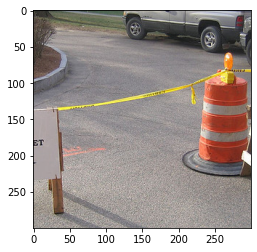

In [0]:
test = get_images('/content/gdrive/My Drive/val2017', 1)
plt.imshow(img.array_to_img(test[0]))
# plt.imshow(img.array_to_img(lr_images(test, 4)[0]))
plt.imshow(img.array_to_img(denormalize(normalize(test)[0])))

In [0]:
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LeakyReLU, PReLU
from tensorflow.keras.layers import add

# Residual block
def res_block_gen(model, kernal_size, filters, strides):    
    gen = model
    
    model = Conv2D(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)
    # Using Parametric ReLU
    model = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(model)
    model = Conv2D(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)
        
    model = add([gen, model])
    
    return model
    
    
def up_sampling_block(model, kernal_size, filters, strides):
    
    # In place of Conv2D and UpSampling2D we can also use Conv2DTranspose (Both are used for Deconvolution)
    # Even we can have our own function for deconvolution (i.e one made in Utils.py)
    #model = Conv2DTranspose(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = Conv2D(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = UpSampling2D(size = 2)(model)
    model = LeakyReLU(alpha = 0.2)(model)
    
    return model
  
class Generator(object):
    def __init__(self, noise_shape):
        
        self.noise_shape = noise_shape
    def generator(self):
        
        gen_input = Input(shape = self.noise_shape)
     
        model = Conv2D(filters = 64, kernel_size = 9, strides = 1, padding = "same")(gen_input)
        model = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(model)
        
        gen_model = model
        
        # Using 5 Residual Blocks
        for index in range(5):
            model = res_block_gen(model, 3, 64, 1)
     
        model = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = "same")(model)
        model = BatchNormalization(momentum = 0.5)(model)
        model = add([gen_model, model])
     
        # Using 2 UpSampling Blocks
        for index in range(2):
            model = up_sampling_block(model, 3, 256, 1)
     
        model = Conv2D(filters = 3, kernel_size = 9, strides = 1, padding = "same")(model)
        model = Activation('tanh')(model)
    
        generator_model = Model(inputs = gen_input, outputs = model)
        # generator_model.summary()
        return generator_model

In [0]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LeakyReLU

def discriminator_block(model, filters, kernel_size, strides):
    
    model = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)
    model = LeakyReLU(alpha = 0.2)(model)
    
    return model
  
class Discriminator(object):

    def __init__(self, image_shape):
        
        self.image_shape = image_shape
    
    def discriminator(self):
        
        dis_input = Input(shape = self.image_shape)
        
        model = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = "same")(dis_input)
        model = LeakyReLU(alpha = 0.2)(model)
        
        model = discriminator_block(model, 64, 3, 2)
        model = discriminator_block(model, 128, 3, 1)
        model = discriminator_block(model, 128, 3, 2)
        model = discriminator_block(model, 256, 3, 1)
        model = discriminator_block(model, 256, 3, 2)
        model = discriminator_block(model, 512, 3, 1)
        model = discriminator_block(model, 512, 3, 2)
        
        model = Flatten()(model)
        model = Dense(512)(model)
        model = LeakyReLU(alpha = 0.2)(model)
       
        model = Dense(1)(model)
        model = Activation('sigmoid')(model) 
        
        discriminator_model = Model(inputs = dis_input, outputs = model)
        # discriminator_model.summary()
        
        return discriminator_model

In [0]:
#@title Loss as a Class
from tensorflow.keras.applications.vgg19 import VGG19
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

class VGG_LOSS(object):

    def __init__(self, image_shape):
        
        self.image_shape = image_shape

    # computes VGG loss or content loss
    def vgg_loss(self, y_true, y_pred):
    
        vgg19 = VGG19(include_top=False, weights='imagenet', input_shape=self.image_shape)
        vgg19.trainable = False
        # Make trainable as False
        for l in vgg19.layers:
            l.trainable = False
        model = Model(inputs=vgg19.input, outputs=vgg19.get_layer('block5_conv4').output)
        model.trainable = False
    
        return K.mean(K.square(model(y_true) - model(y_pred)))
    
def get_optimizer():
 
    adam = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    return adam

In [0]:
from tensorflow.keras.applications.vgg19 import VGG19
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def VGG_loss(image_shape):
    def loss(y_true, y_pred):
        vgg19 = VGG19(include_top=False, weights='imagenet', input_shape=image_shape)
        vgg19.trainable = False
        # Make trainable as False
        for l in vgg19.layers:
            l.trainable = False
        model = Model(inputs=vgg19.input, outputs=vgg19.get_layer('block5_conv4').output)
        model.trainable = False
        return K.mean(K.square(model(y_true)-model(y_pred)))
    return loss
def get_optimizer():
 
    adam = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    return adam

In [0]:
#@title Get Gan Network (old)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

def get_gan_network(discriminator, shape, generator, optimizer, vgg_loss):
    discriminator.trainable = False
    gan_input = Input(shape=shape)
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=[x,gan_output])
    gan.compile(loss=[vgg_loss, "binary_crossentropy"], loss_weights=[1., 1e-3], optimizer=optimizer)
    gan.summary()

    return gan

In [0]:
from numpy import array
from numpy.random import randint
import matplotlib.pyplot as plt

def plot_generated_images(output_dir, epoch, generator, x_test_hr, x_test_lr , dim=(1, 3), figsize=(15, 5)):
    
    examples = x_test_hr.shape[0]
    print(examples)
    value = randint(0, examples)
    image_batch_hr = img.array_to_img(denormalize(x_test_hr))
    image_batch_lr = img.array_to_img(x_test_lr)
    gen_img = generator.predict(image_batch_lr)
    generated_image = img.array_to_img(denormalize(gen_img))
    image_batch_lr = img.array_to_img(denormalize(image_batch_lr))
    
    plt.figure(figsize=figsize)
    
    plt.subplot(dim[0], dim[1], 1)
    plt.imshow(image_batch_lr[value], interpolation='nearest')
    plt.axis('off')
        
    plt.subplot(dim[0], dim[1], 2)
    plt.imshow(generated_image[value], interpolation='nearest')
    plt.axis('off')
    
    plt.subplot(dim[0], dim[1], 3)
    plt.imshow(image_batch_hr[value], interpolation='nearest')
    plt.axis('off')
    
    plt.tight_layout()
    plt.savefig(output_dir + 'generated_image_%d.png' % epoch)
    
    #plt.show()

In [0]:
from numpy import array
from numpy.random import randint
import matplotlib.pyplot as plt

def plot_generated_images(output_dir, epoch, generator, x_test_hr, x_test_lr , dim=(1, 3), figsize=(15, 5)):
    
    examples = x_test_hr.shape[0]
    print(examples)
    value = randint(0, examples)
    image_hr = img.array_to_img(x_test_hr[value])
    image_lr = x_test_lr[value]
    gen_img = generator.predict(np.expand_dims(image_lr, axis = 0))
    generated_image = img.array_to_img(np.squeeze(gen_img, axis = 0))
    image_lr = img.array_to_img(image_lr)
    
    plt.figure(figsize=figsize)
    
    plt.subplot(dim[0], dim[1], 1)
    plt.imshow(image_lr, interpolation='nearest')
    plt.axis('off')
        
    plt.subplot(dim[0], dim[1], 2)
    plt.imshow(generated_image, interpolation='nearest')
    plt.axis('off')
    
    plt.subplot(dim[0], dim[1], 3)
    plt.imshow(image_hr, interpolation='nearest')
    plt.axis('off')
    
    plt.tight_layout()
    plt.savefig(output_dir + 'generated_image_%d.png' % epoch)
    
    #plt.show()

In [0]:
from tensorflow.keras.layers import Input
from tensorflow.keras import Model

def compile_gan(shape, downscale, discriminator, generator, loss):
    discriminator.trainable = False
    shape = (shape[0] // downscale, shape[1] // downscale, 3)
    gan_input = Input(shape = shape)
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=[x,gan_output])
    gan.compile(loss=[loss, "binary_crossentropy"], loss_weights=[1., 1e-3], optimizer=get_optimizer())
    return gan

class GAN(object):

    def __init__(self, input_shape, downscale):
      self.downscale = downscale
      self.input_shape = input_shape
      generator_shape = (input_shape[0] // downscale, input_shape[1] // downscale, 3)
      self.gen = Generator(noise_shape = generator_shape).generator()
      self.discr = Discriminator(image_shape = input_shape).discriminator()
      self.loss = VGG_loss(input_shape)
      self.gan = compile_gan(self.input_shape, self.downscale, self.discr, self.gen, self.loss)
    def train(self, epochs, batch_size, input_imgs, output_dir, model_save_dir):
      x_train_lr, x_train_hr, x_test_lr, x_test_hr = input_imgs
      loss =  self.loss
      image_shape = self.input_shape
      downscale_factor = self.downscale

      batch_count = int(x_train_hr.shape[0] / batch_size)
      shape = (image_shape[0]//downscale_factor, image_shape[1]//downscale_factor, image_shape[2])
    
      generator = self.gen
      discriminator = self.discr

      optimizer = get_optimizer()
      generator.compile(loss=loss, optimizer=optimizer)
      discriminator.compile(loss="binary_crossentropy", optimizer=optimizer)
    
      gan = self.gan
    
      loss_file = open(model_save_dir + 'losses.txt' , 'w+')
      loss_file.close()
      for e in range(1, epochs+1):
        print ('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(batch_count)):
            
            rand_nums = np.random.randint(0, x_train_hr.shape[0], size=batch_size)
            
            image_batch_hr = x_train_hr[rand_nums]
            image_batch_lr = x_train_lr[rand_nums]
            generated_images_sr = generator.predict(image_batch_lr)

            real_data_Y = np.ones(batch_size) - np.random.random_sample(batch_size)*0.2
            fake_data_Y = np.random.random_sample(batch_size)*0.2
            
            discriminator.trainable = True
            
            d_loss_real = discriminator.train_on_batch(image_batch_hr, real_data_Y)
            d_loss_fake = discriminator.train_on_batch(generated_images_sr, fake_data_Y)
            discriminator_loss = 0.5 * np.add(d_loss_fake, d_loss_real)
            
            rand_nums = np.random.randint(0, x_train_hr.shape[0], size=batch_size)
            image_batch_hr = x_train_hr[rand_nums]
            image_batch_lr = x_train_lr[rand_nums]

            gan_Y = np.ones(batch_size) - np.random.random_sample(batch_size)*0.2
            discriminator.trainable = False
            gan_loss = gan.train_on_batch(image_batch_lr, [image_batch_hr,gan_Y])
            
            
        print("discriminator_loss : %f" % discriminator_loss)
        print("gan_loss :", gan_loss)
        gan_loss = str(gan_loss)
        
        loss_file = open(model_save_dir + 'losses.txt' , 'a')
        loss_file.write('epoch%d : gan_loss = %s ; discriminator_loss = %f\n' %(e, gan_loss, discriminator_loss) )
        loss_file.close()

        if e == 1 or e % 10 == 0:
            plot_generated_images(output_dir, e, generator, x_test_hr, x_test_lr)
        if e % 100 == 0:
            generator.save(model_save_dir + 'gen_model%d.h5' % e)
            discriminator.save(model_save_dir + 'dis_model%d.h5' % e)

In [0]:
#@title GAN with class implemented Loss
from tensorflow.keras.layers import Input
from tensorflow.keras import Model

def compile_gan(shape, downscale, discriminator, generator, loss):
    discriminator.trainable = False
    shape = (shape[0] // downscale, shape[1] // downscale, 3)
    gan_input = Input(shape = shape)
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=[x,gan_output])
    gan.compile(loss=[loss, "binary_crossentropy"], loss_weights=[1., 1e-3], optimizer=get_optimizer())
    return gan

class GAN(object):

    def __init__(self, input_shape, downscale):
      self.downscale = downscale
      self.input_shape = input_shape
      generator_shape = (input_shape[0] // downscale, input_shape[1] // downscale, 3)
      self.gen = Generator(noise_shape = generator_shape).generator()
      self.discr = Discriminator(image_shape = input_shape).discriminator()
      self.loss = VGG_LOSS(input_shape)
      self.gan = compile_gan(self.input_shape, self.downscale, self.discr, self.gen, self.loss.vgg_loss)
    def train(self, epochs, batch_size, input_imgs, output_dir, model_save_dir):
      x_train_lr, x_train_hr, x_test_lr, x_test_hr = input_imgs
      loss =  self.loss
      image_shape = self.input_shape
      downscale_factor = self.downscale

      batch_count = int(x_train_hr.shape[0] / batch_size)
      shape = (image_shape[0]//downscale_factor, image_shape[1]//downscale_factor, image_shape[2])
    
      generator = self.gen
      discriminator = self.discr

      optimizer = get_optimizer()
      generator.compile(loss=loss.vgg_loss,optimizer=optimizer)
      discriminator.compile(loss="binary_crossentropy", optimizer=optimizer)
    
      gan = self.gan
    
      loss_file = open(model_save_dir + 'losses.txt' , 'w+')
      loss_file.close()
      for e in range(1, epochs+1):
        print ('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(batch_count)):
            
            rand_nums = np.random.randint(0, x_train_hr.shape[0], size=batch_size)
            
            image_batch_hr = x_train_hr[rand_nums]
            image_batch_lr = x_train_lr[rand_nums]
            generated_images_sr = generator.predict(image_batch_lr)

            real_data_Y = np.ones(batch_size) - np.random.random_sample(batch_size)*0.2
            fake_data_Y = np.random.random_sample(batch_size)*0.2
            
            discriminator.trainable = True
            
            d_loss_real = discriminator.train_on_batch(image_batch_hr, real_data_Y)
            d_loss_fake = discriminator.train_on_batch(generated_images_sr, fake_data_Y)
            discriminator_loss = 0.5 * np.add(d_loss_fake, d_loss_real)
            
            rand_nums = np.random.randint(0, x_train_hr.shape[0], size=batch_size)
            image_batch_hr = x_train_hr[rand_nums]
            image_batch_lr = x_train_lr[rand_nums]

            gan_Y = np.ones(batch_size) - np.random.random_sample(batch_size)*0.2
            discriminator.trainable = False
            gan_loss = gan.train_on_batch(image_batch_lr, [image_batch_hr,gan_Y])
            
            
        print("discriminator_loss : %f" % discriminator_loss)
        print("gan_loss :", gan_loss)
        gan_loss = str(gan_loss)
        
        loss_file = open(model_save_dir + 'losses.txt' , 'a')
        loss_file.write('epoch%d : gan_loss = %s ; discriminator_loss = %f\n' %(e, gan_loss, discriminator_loss) )
        loss_file.close()

        if e == 1 or e % 10 == 0:
            plot_generated_images(output_dir, e, generator, x_test_hr, x_test_lr)
        if e % 100 == 0:
            generator.save(model_save_dir + 'gen_model%d.h5' % e)
            discriminator.save(model_save_dir + 'dis_model%d.h5' % e)

In [0]:
im_directory = '/content/gdrive/My Drive/val2017'
im_num = 100
downscale_ratio  = 4

img_data = load_data(im_directory, im_num, downscale_ratio)
# plt.imshow(img_data[0][0])

10 images uploaded
20 images uploaded
30 images uploaded
40 images uploaded
50 images uploaded
60 images uploaded
70 images uploaded
80 images uploaded
90 images uploaded
100 images uploaded
100 images uploaded in total


  0%|          | 0/10 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


100%|██████████| 10/10 [01:02<00:00,  6.21s/it]


discriminator_loss : 0.863251
gan_loss : [34.078426, 34.07708, 1.3454944]
50


  0%|          | 0/10 [00:00<?, ?it/s]

--------------- Epoch 2 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]

discriminator_loss : 0.883356
gan_loss : [31.980791, 31.980194, 0.5963148]
--------------- Epoch 3 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]

discriminator_loss : 0.708046
gan_loss : [50.05365, 50.052696, 0.9533927]
--------------- Epoch 4 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]

discriminator_loss : 0.614648
gan_loss : [49.49887, 49.497887, 0.9846221]
--------------- Epoch 5 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]

discriminator_loss : 0.664262
gan_loss : [32.38133, 32.380108, 1.2214248]
--------------- Epoch 6 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]

discriminator_loss : 1.044489
gan_loss : [66.93938, 66.938545, 0.83287495]
--------------- Epoch 7 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]

discriminator_loss : 0.715033
gan_loss : [44.67254, 44.67173, 0.8068342]
--------------- Epoch 8 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]

discriminator_loss : 0.683196
gan_loss : [72.50882, 72.50786, 0.96422136]
--------------- Epoch 9 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]

discriminator_loss : 0.623191
gan_loss : [57.7783, 57.77743, 0.8712673]
--------------- Epoch 10 ---------------


100%|██████████| 10/10 [00:25<00:00,  2.58s/it]


discriminator_loss : 0.810280
gan_loss : [52.57504, 52.57395, 1.0874279]
50


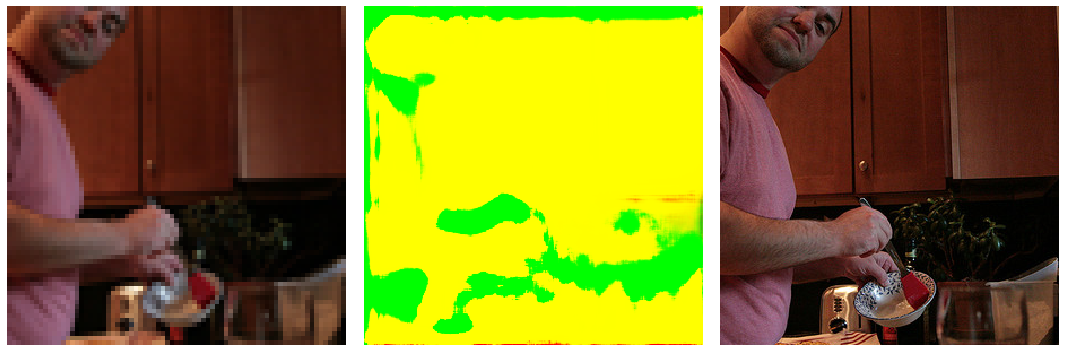

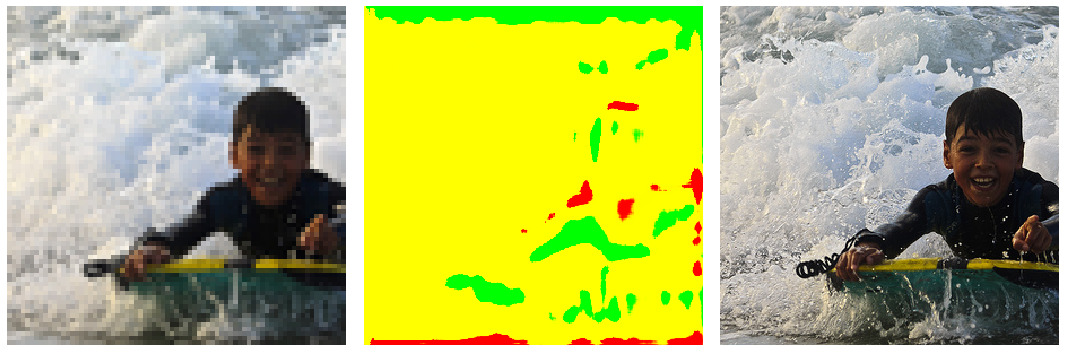

In [49]:
from tqdm import tqdm
import numpy as np

# Better to use downscale factor as 4
downscale_factor = 4
# Remember to change image shape if you are having different size of images
image_shape = (300,300,3)

gan = GAN(image_shape, downscale_factor)
gan.train(epochs = 10, batch_size = 5, input_imgs = img_data, output_dir = '/content/gdrive/My Drive/SR_Output', model_save_dir = '/content/gdrive/My Drive/SR_Model')

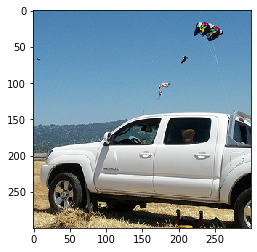

In [43]:
import matplotlib.pyplot as plt
plt.imshow(img.array_to_img(img_data[3][10]), interpolation='nearest')